In [1]:
import demo_util
import numpy as np
import torch
from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.one_d_piece import OneDPiece

In [2]:
# load the pretrained models from huggingface
# hf_hub_download(repo_id="turing-motors/One-D-Piece-L-256", filename="pytorch_model.bin", local_dir="./")
# hf_hub_download(repo_id="turing-motors/MaskGIT_One-D-Piece-L-256", filename="pytorch_model.bin", local_dir="./")

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(42)

## Prepare the TiTok models

In [4]:
config = demo_util.get_config("configs/one-d-piece_l256.yaml")

In [5]:
print(config)

{'experiment': {'project': 'one_d_piece_l256', 'name': 'one_d_piece_l256_eval', 'output_dir': 'checkpoints/one_d_piece_l256_stage2_run1', 'max_train_examples': 1281167, 'save_every': 10000, 'eval_every': 10000, 'generate_every': 500, 'log_every': 50, 'log_grad_norm_every': 1000, 'resume': True, 'explanation': 'One-D-Pieceをl256サイズで作る', 'length': 256}, 'model': {'type': 'one_d_piece', 'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'large', 'vit_dec_model_size': 'large', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 256, 'finetune_decoder': True, 'strict_length_assertion': False}}, 'losses': {'discriminator_start': 20000, 'quantizer_weight': 0.0, 'discriminator_factor': 1.0, 'discriminator_weight': 0.01, 'perceptual_loss': 'convnext_s', 'perceptual_weight': 0.1, 'reconstruction_loss': 'l2', 'reconstruction_weight': 1.0, 'lecam_regularization_weight': 0.001}, 'dataset': {'params': {'train_

In [6]:
tokenizer = OneDPiece(config)
tokenizer.load_state_dict(torch.load("one-d-piece_l256.bin"))
tokenizer.eval()
tokenizer.requires_grad_(False)

print(tokenizer)

OneDPiece(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(1024, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, 

In [7]:
generator_config = demo_util.get_config("configs/training/generator/maskgit_one-d-piece_l256.yaml")
generator = ImageBert(generator_config)
generator.load_state_dict(torch.load("maskgit_one-d-piece_l256.bin"))
generator.eval()
generator.requires_grad_(False)

print(generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 768)
      (position_embeddings): Embedding(257, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [8]:
device = "cuda"

In [9]:
tokenizer = tokenizer.to(device)
generator = generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [10]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path, length=256):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = tokenizer.decode_tokens(encoded_tokens[:, :, :length])
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

Input Image is represented by codes tensor([[[ 904, 2060, 2242, 3993, 2945, 3355, 3644,  936, 2685, 2270, 1009,
            31,  527,  798,  721,  155,  895, 2701, 1901, 1725, 2672,  590,
          3643, 4054,  618, 1936, 2093, 3192, 3009, 1517,  434, 1303, 1637,
          3141, 3718,  717, 2773, 3243,  973, 2858, 2137, 2546, 3696, 3455,
          1674,  467, 2576, 1804, 3818, 2934, 1163,   81, 1657,  366,  800,
          4068, 1861,  462, 1565, 3385, 2361, 1642, 1019,  698, 1178, 3230,
           827, 2033,  526,  914, 3743, 2723, 3443, 2470, 3637,  447, 1737,
            45,  589, 3630, 3455, 1312, 2581, 2471, 2336, 2490, 3446, 3732,
           562, 4077,  712, 3801, 1924, 1750, 3903, 2200, 3052, 3280, 3042,
            99,  115, 2192, 1767,  178, 1711, 2741, 3710,  171, 1703, 2585,
          1379, 3760, 1155, 3164, 2064,  512, 1180,  257,  533, 1180, 1327,
          1680,  873, 2054, 2100, 2885, 2523, 1701, 1665, 3502, 4056, 1598,
          2667, 1186, 3906, 3798, 3491, 2477,  217, 

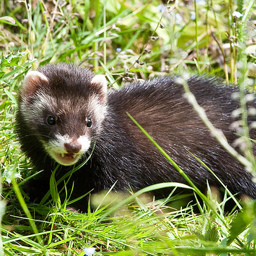

reconstructed image:


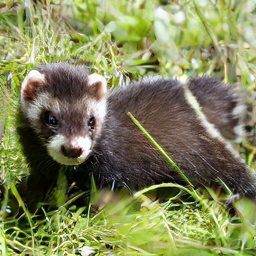

In [11]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")

Input Image is represented by codes tensor([[[ 904, 2060, 2242, 3993, 2945, 3355, 3644,  936, 2685, 2270, 1009,
            31,  527,  798,  721,  155,  895, 2701, 1901, 1725, 2672,  590,
          3643, 4054,  618, 1936, 2093, 3192, 3009, 1517,  434, 1303, 1637,
          3141, 3718,  717, 2773, 3243,  973, 2858, 2137, 2546, 3696, 3455,
          1674,  467, 2576, 1804, 3818, 2934, 1163,   81, 1657,  366,  800,
          4068, 1861,  462, 1565, 3385, 2361, 1642, 1019,  698, 1178, 3230,
           827, 2033,  526,  914, 3743, 2723, 3443, 2470, 3637,  447, 1737,
            45,  589, 3630, 3455, 1312, 2581, 2471, 2336, 2490, 3446, 3732,
           562, 4077,  712, 3801, 1924, 1750, 3903, 2200, 3052, 3280, 3042,
            99,  115, 2192, 1767,  178, 1711, 2741, 3710,  171, 1703, 2585,
          1379, 3760, 1155, 3164, 2064,  512, 1180,  257,  533, 1180, 1327,
          1680,  873, 2054, 2100, 2885, 2523, 1701, 1665, 3502, 4056, 1598,
          2667, 1186, 3906, 3798, 3491, 2477,  217, 

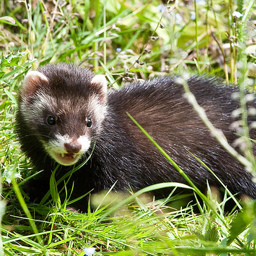

reconstructed image:


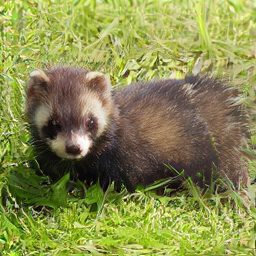

In [12]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png", length=32)

Input Image is represented by codes tensor([[[3564, 3302, 2161, 2999,  426, 3671,  705,  731, 2790, 2179, 1888,
          3569, 4022, 2665, 1193, 3119, 2466,  697, 2851, 1471, 3585, 2289,
          2371, 3980, 3333, 1615, 2382, 2386, 1822, 3048, 2592,  617, 1364,
          3034,  204,   66, 2223, 1483, 1031, 3306, 1538,  839, 2165, 3335,
          1837,  430, 3326, 3676, 3890, 3599,  853,  269, 2844,  758, 2872,
          3408,  250, 2013, 3815,   33,  805, 1313, 3146,  219,  738,  507,
           151, 2310, 2580, 3464,  369, 1501, 2084, 3024,  925, 2649, 1329,
          2640, 1723, 2370, 3515, 3400,  741, 3758, 3906, 1891, 1454,   24,
          3733, 3104,  862, 3441, 1053,  382, 1650, 3365, 3473,  381,  182,
          3623, 3648, 2937, 1641,  660, 3625, 3933, 2475, 2033, 3097,  556,
          3222,  231, 2089, 2148, 2839,  837, 1284, 1924, 1849, 2917,  712,
          2940, 3075,  558, 3753, 1745, 2845, 1137, 3090, 3147, 1574, 2475,
          1895,  365, 2593,  611, 3937, 2513,  470, 

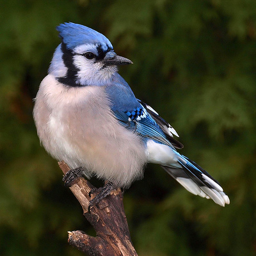

reconstructed image:


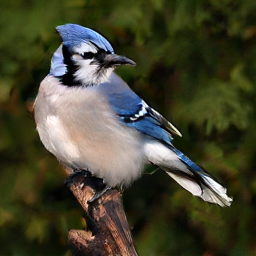

In [13]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

Input Image is represented by codes tensor([[[3564, 3302, 2161, 2999,  426, 3671,  705,  731, 2790, 2179, 1888,
          3569, 4022, 2665, 1193, 3119, 2466,  697, 2851, 1471, 3585, 2289,
          2371, 3980, 3333, 1615, 2382, 2386, 1822, 3048, 2592,  617, 1364,
          3034,  204,   66, 2223, 1483, 1031, 3306, 1538,  839, 2165, 3335,
          1837,  430, 3326, 3676, 3890, 3599,  853,  269, 2844,  758, 2872,
          3408,  250, 2013, 3815,   33,  805, 1313, 3146,  219,  738,  507,
           151, 2310, 2580, 3464,  369, 1501, 2084, 3024,  925, 2649, 1329,
          2640, 1723, 2370, 3515, 3400,  741, 3758, 3906, 1891, 1454,   24,
          3733, 3104,  862, 3441, 1053,  382, 1650, 3365, 3473,  381,  182,
          3623, 3648, 2937, 1641,  660, 3625, 3933, 2475, 2033, 3097,  556,
          3222,  231, 2089, 2148, 2839,  837, 1284, 1924, 1849, 2917,  712,
          2940, 3075,  558, 3753, 1745, 2845, 1137, 3090, 3147, 1574, 2475,
          1895,  365, 2593,  611, 3937, 2513,  470, 

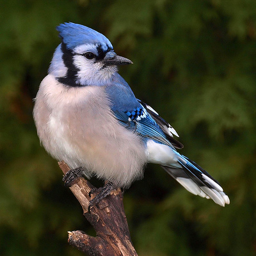

reconstructed image:


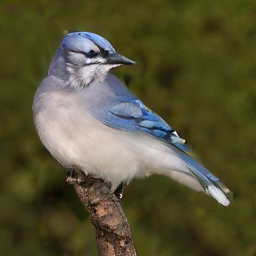

In [14]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png", length=32)

## Generate an image from 32 discrete tokens

labels 14, indigo bunting, indigo finch, indigo bird, Passerina cyanea


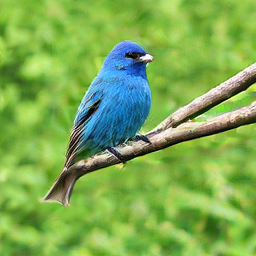

In [15]:
#sample_labels = [torch.randint(0, 999, size=(1,)).item()]
# bird
sample_labels = [14]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=generator,
    tokenizer=tokenizer,
    labels=sample_labels,
    guidance_scale=6.0,
    randomize_temperature=1.2,
    num_sample_steps=32,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))